In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

try:
    from pymatsolver import Pardiso as Solver
except ImportError:
    from SimPEG import SolverLU as Solver
    
import discretize
from discretize.utils import mkvc

from SimPEG import (
    maps,
    data,
    optimization,
    data_misfit,
    regularization,
    inverse_problem,
    inversion,
    directives,
    Report,
    utils
)
from SimPEG.electromagnetics import frequency_domain as fdem

In [140]:
write_output = True

## Setup 3D Model

In [5]:
resistivity_surface = 1000
resistivity_middle = 10
resistivity_deep = 100
resistivity_air = 1e8

## Forward Modelling Mesh

the mesh has 4368 cells


C:\Users\sabri\AppData\Local\Temp\ipykernel_10200\331272648.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ncx = int(np.diff(core_domain_x) / csx)
C:\Users\sabri\AppData\Local\Temp\ipykernel_10200\331272648.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ncz = int(np.diff(core_domain_z) / csz)


<Axes3D: xlabel='x1', ylabel='x2', zlabel='x3'>

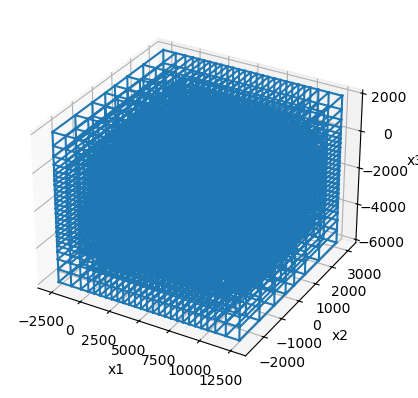

In [6]:
csx = 500  # cell size for the horizontal direction
csz = 250  # cell size for the vertical direction
pf = 1.3  # expansion factor for the padding cells

npadx = 3  # number of padding cells in the x-direction
npady = 3  # number of padding cells in the y-direction
npadz = 4  # number of padding cells in the z-direction

core_domain_x = np.r_[0, 10000]  # extent of uniform cells in the x-direction
core_domain_z = np.r_[-4000, 0]  # extent of uniform cells in the z-direction

# number of cells in the core region
ncx = int(np.diff(core_domain_x) / csx)
ncz = int(np.diff(core_domain_z) / csz)

# create a 3D tensor mesh
mesh = discretize.TensorMesh(
    [
        [(csx, npadx, -pf), (csx, ncx), (csx, npadx, pf)],
        [(csx, npady, -pf), (csx, 1), (csx, npady, pf)],
        [(csz, npadz, -pf), (csz, ncz), (csz, npadz, pf)],
    ]
)

mesh.x0 = np.r_[
    -mesh.h[0][: npadx].sum(), -mesh.h[1][: npady].sum(), -mesh.h[2][: npadz + ncz].sum()
]

print("the mesh has {} cells".format(mesh.nC))
mesh.plot_grid()

In [73]:
# Save the mesh
# mesh.save(file_name="3d_mesh.json")

'c:\\Users\\sabri\\OneDrive\\Documents\\UBC Coursework\\eosc-454\\EOSC454-Project-SabrinaAshik\\3d_files\\3d_mesh.json'

## 2D Inversion Mesh

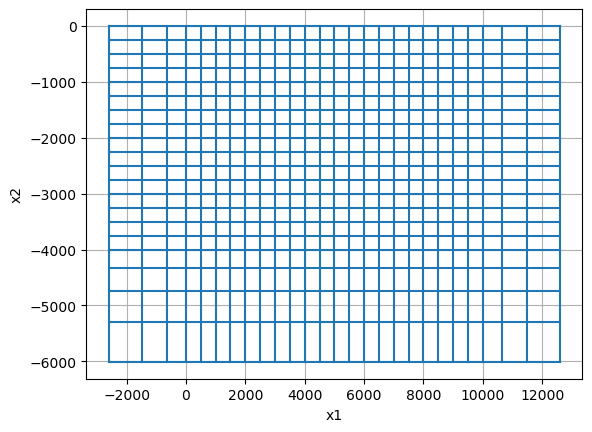

In [7]:
inversion_mesh_2d = discretize.TensorMesh([mesh.h[0], mesh.h[2][mesh.cell_centers_z <= 0]])
inversion_mesh_2d.x0 = [-inversion_mesh_2d.h[0][mesh.cell_centers_x <= 0].sum(), -inversion_mesh_2d.h[1].sum()]
ax = inversion_mesh_2d.plot_grid()

In [ ]:
#save the inversion mesh
# inversion_mesh_2d.save(file_name="inversion_mesh_2d.json")

## Mapping

In [100]:
# create a 2D mesh that includes air cells
mesh2D = discretize.TensorMesh([mesh.h[0], mesh.h[2]], x0=mesh.x0[[0, 2]])
active_inds = mesh2D.gridCC[:, 1] < 0  # active indices are below the surface


mapping = (
    maps.Surject2Dto3D(mesh)
    * maps.InjectActiveCells(  # populates 3D space from a 2D model
        mesh2D, active_inds, resistivity_air
    )
    * maps.ExpMap(  # adds air cells
        nP=inversion_mesh_2d.nC
    )
)

In [93]:
mapping.shape

(4368, 520)

## 1D Inversion Mesh

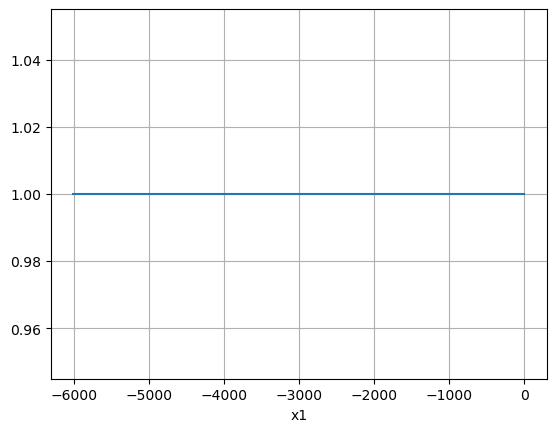

In [114]:
inversion_mesh_1d = discretize.TensorMesh([mesh.h[2][mesh.cell_centers_z <= 0]])
inversion_mesh_1d.x0 = [-inversion_mesh_1d.h[0].sum()]
ax = inversion_mesh_1d.plot_grid()

In [118]:
mesh1D = discretize.TensorMesh([mesh.h[2]], x0=mesh.x0[[2]])
active_inds_1d = mesh1D.gridCC[:] < 0  # active indices are below the surface
mapping_1d = (
    maps.SurjectVertical1D(mesh)
    *maps.InjectActiveCells(  # populates 3D space from a 2D model
        mesh1D, active_inds_1d, resistivity_air
    )
    *maps.ExpMap(nP=inversion_mesh_1d.nC)
    )

## True Model

In [110]:
# Define interface parameters
interfaces = [
    {
        'z_shallow': -500,
        'z_deep': -1000,
        'x_dip': np.r_[5000, 9000]
    },
    {
        'z_shallow': -1000,
        'z_deep': -2500,
        'x_dip': np.r_[2000, 7000]
    }
]

In [89]:
def interface(x, inferfaces=interfaces):

    boundaries = []
    for i, keys in enumerate(interfaces):
        z1, z2, x_dip = keys.values()
        temp = np.zeros_like(x)
        if i ==0:
            temp[x < x_dip[0]] = z1
        dipping_unit = (x >= x_dip[0]) & (x <= x_dip[1])
        x_dipping = (-(z1 - z2) / (x_dip[1]- x_dip[0])) * x[dipping_unit]
        x_dipping = x_dipping - x_dipping[0] + z1
        temp[dipping_unit] = x_dipping
        temp[x > x_dip[1]] = z2
        boundaries.append(temp)

    return boundaries[0], boundaries[1]

(-4000.0, 0.0)

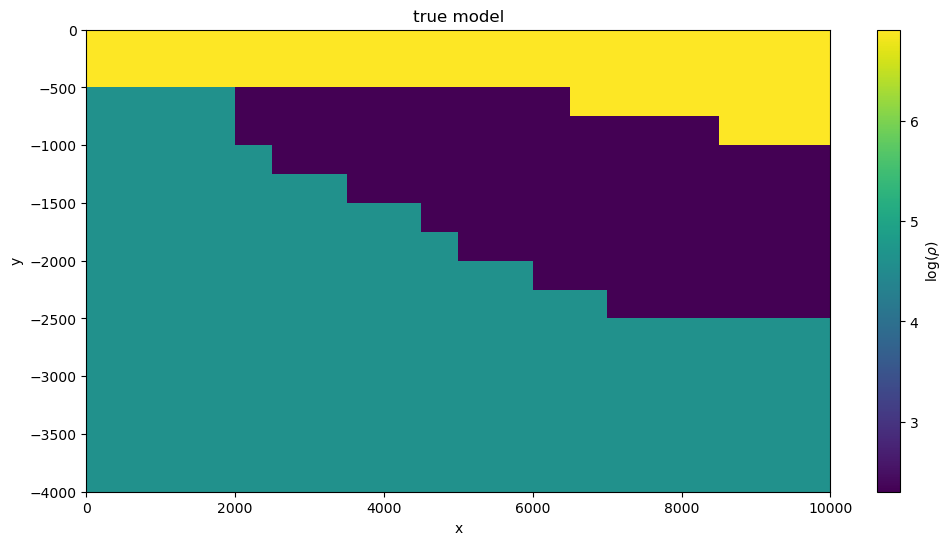

In [90]:
m_true = np.log(resistivity_deep) * np.ones(inversion_mesh_2d.nC)
interface_1, interface_2 = interface(inversion_mesh_2d.gridCC[:, 0])
m_true[inversion_mesh_2d.gridCC[:, 1] > interface_2] = np.log(resistivity_middle)
m_true[inversion_mesh_2d.gridCC[:, 1] > interface_1] = np.log(resistivity_surface)

fig, ax = plt.subplots(1, 1, figsize=(12,6))
cb = plt.colorbar(inversion_mesh_2d.plot_image(m_true, ax=ax)[0], ax=ax)
cb.set_label(r"$\log(\rho)$")
ax.set_title("true model")
ax.set_xlim([0, 10.0e3])
ax.set_ylim([-4.0e3, 0])
# ax.minorticks_on()
# ax.grid(True, which="both")

## 1D Data Collection (1DLayered)

In [132]:
def get_1D_model(x_position):
    # Find index of the x-position and the indices of grid cell centers that have the specified x-position
    x_index = np.where(inversion_mesh_2d.gridCC[:, 0]>= x_position)[0][0]
    x_indices = np.where(np.isclose(inversion_mesh_2d.gridCC[:, 0], inversion_mesh_2d.gridCC[:, 0][x_index]))

    # Get the z-values corresponding to the specified x-position
    z_values_mesh = inversion_mesh_2d.gridCC[x_indices, 1][0]
    z_values_mesh = z_values_mesh[::-1] + (inversion_mesh_2d.h[1][::-1])/2
    z_values_mesh = np.round(z_values_mesh)

    z_values_model = m_true[x_indices][::-1]

    unique_values, indices = np.unique(z_values_model, return_index=True)

    # Define 1D model from the 3D model
    log_resistivity_model = unique_values[np.argsort(indices)]

    layers = []
    layer_indices = np.sort(indices)
    for i in range(len(layer_indices)-1):
        idx = layer_indices[i+1]
        thickness = abs(z_values_mesh[idx])
        if i > 0:
            thickness = thickness - sum(layers[:i])
        layers.append(thickness)

    layer_thicknesses = np.array(layers)

    log_resistivity_map = maps.ExpMap(nP=len(layer_thicknesses)+1)

    return layer_thicknesses, log_resistivity_map, log_resistivity_model, z_values_model

In [ ]:
frequencies = np.logspace(-4, 6, 15)

x_positions = np.arange(0, 10000, 500)

# Defining transmitter locations
xtx, ytx, ztx = np.meshgrid(x_positions, [0], [30])
source_locations = np.c_[mkvc(xtx), mkvc(ytx), mkvc(ztx)]
ntx = np.size(xtx)

# Define receiver locations
xrx, yrx, zrx = np.meshgrid(x_positions + 10, [0], [30])
receiver_locations = np.c_[mkvc(xrx), mkvc(yrx), mkvc(zrx)]

source_list = []  # Create empty list to store sources

dpreds = []

# Each unique location and frequency defines a new transmitter
for ii in range(ntx):
    source_list = [] 
    # Define receivers of different type at each location
    bzr_receiver = fdem.receivers.PointMagneticFluxDensitySecondary(
        receiver_locations[ii, :], "z", "real"
    )

    bzi_receiver = fdem.receivers.PointMagneticFluxDensitySecondary(
        receiver_locations[ii, :], "z", "imag"
    )
    receivers_list = [bzr_receiver, bzi_receiver]
    for jj in range(len(frequencies)):
        # Must define the transmitter properties and associated receivers
        source_list.append(
            fdem.sources.MagDipole(
                receivers_list,
                frequencies[jj],
                source_locations[ii, :],
                orientation="z",
                momemt = 1
            )
        )

    # create the survey and problem objects for running the forward simulation
    survey = fdem.Survey(source_list)
    layer_thicknesses, log_resistivity_map, log_resistivity_model = get_1D_model(source_locations[ii, 0])
    sim = fdem.Simulation1DLayered(
        survey=survey,
        thicknesses=layer_thicknesses,
        rhoMap=log_resistivity_map,
    )
    dpreds.append(sim.dpred(log_resistivity_model))


### Plot 1d data for a certain location

In [ ]:
location_index = 0
d  = dpreds[location_index]
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.semilogx(frequencies, (10**9)*d[0::2], "r-o", lw=3)
ax.semilogx(frequencies, (10**9)*d[1::2], "b:o", lw=3)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Bz Seconds [nT]")
ax.set_title("Magnetic Field Data")
ax.legend(["Real", "Imaginary"])
plt.show()


### Save Data

In [ ]:
if write_output:
    # Get the directory of the current notebook
    notebook_dir = os.getcwd()
    dir_path = os.path.join(notebook_dir, "3d_simulation_data")
    
    # Ensure the directory exists, create it if not
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

    np.random.seed(222)
    noise_level = 0.00 # Change this

    data = []

    for d in dpreds:
        noise = noise_level * np.abs(d) * np.random.rand(len(d))
        d += noise
        data.append(d[0::2]) # add real data
        data.append(d[1::2]) # add imaginary data
    
    fname = os.path.join(dir_path, "em3dfm_1d_data.txt")
    np.savetxt(
        fname,
        np.c_[frequencies, *data], #needed to modify this line
        fmt="%.4e",
        header="FREQUENCY HZ_REAL HZ_IMAG",
    )

## 3D Data Collection

In [10]:
frequencies = np.logspace(-4, 6, 15)

x_positions = np.arange(0, 10000, 500)

# Defining transmitter locations
xtx, ytx, ztx = np.meshgrid(x_positions, [0], [30])
source_locations = np.c_[mkvc(xtx), mkvc(ytx), mkvc(ztx)]
ntx = np.size(xtx)

# Define receiver locations
xrx, yrx, zrx = np.meshgrid(x_positions + 10, [0], [30])
receiver_locations = np.c_[mkvc(xrx), mkvc(yrx), mkvc(zrx)]

source_list = []  # Create empty list to store sources

# Each unique location and frequency defines a new transmitter
for ii in range(ntx): 
    # Define receivers of different type at each location
    bzr_receiver = fdem.receivers.PointMagneticFluxDensitySecondary(
        receiver_locations[ii, :], "z", "real"
    )

    bzi_receiver = fdem.receivers.PointMagneticFluxDensitySecondary(
        receiver_locations[ii, :], "z", "imag"
    )
    receivers_list = [bzr_receiver, bzi_receiver]
    for jj in range(len(frequencies)):
        # Must define the transmitter properties and associated receivers
        source_list.append(
            fdem.sources.MagDipole(
                receivers_list,
                frequencies[jj],
                source_locations[ii, :],
                orientation="z",
                momemt = 100
            )
        )
        
# create the survey and problem objects for running the forward simulation
survey = fdem.survey.Survey(source_list)
prob = fdem.Simulation3DMagneticFluxDensity(
    mesh, survey=survey, rhoMap=mapping, solver=Solver
)

In [14]:
dpred = prob.dpred(m_true)

<Figure size 500x500 with 0 Axes>

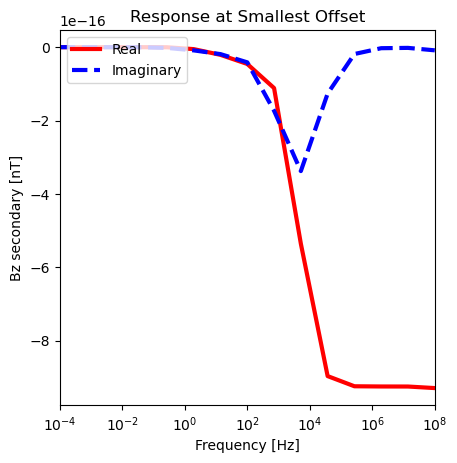

In [15]:
# Data are organized by transmitter location, then component, then frequency. We had nFreq
# transmitters and each transmitter had 2 receivers (real and imaginary component). So
# first we will pick out the real and imaginary data
bz_real = dpred[0 : len(dpred) : 2]
bz_imag = dpred[1 : len(dpred) : 2]

# Then we will will reshape the data.
bz_real = np.reshape(bz_real, (ntx, len(frequencies)))
bz_imag = np.reshape(bz_imag, (ntx, len(frequencies)))

# Plot FEM response for all frequencies
fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_axes([0.2, 0.15, 0.75, 0.75])
location_index = 15
ax1.semilogx(frequencies, bz_real[location_index, :], "r-", lw=3)
ax1.semilogx(frequencies, bz_imag[location_index, :], "b--", lw=3)
ax1.set_xlim((np.min(frequencies), np.max(frequencies)))
ax1.set_xlabel("Frequency [Hz]")
ax1.set_ylabel("Bz secondary [nT]")
ax1.set_title("Response at Smallest Offset")
ax1.legend(["Real", "Imaginary"], loc="upper left")

In [64]:
if write_output:
    # Get the directory of the current notebook
    notebook_dir = os.getcwd()
    dir_path = os.path.join(notebook_dir, "3d_simulation_data")
    
    # Ensure the directory exists, create it if not
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

    np.random.seed(222)
    noise_level = 0.00 # Change this
    noise = noise_level * np.abs(dpred) * np.random.rand(len(dpred))
    dpred_noisy = dpred + noise

    bz_real = dpred_noisy[0 : len(dpred) : 2]
    bz_imag = dpred_noisy[1 : len(dpred) : 2]

    # Then we will will reshape the data.
    bz_real = np.reshape(bz_real, (ntx, len(frequencies)))
    bz_imag = np.reshape(bz_imag, (ntx, len(frequencies)))

    fname = os.path.join(dir_path, "em3dfm_3d_data.txt")
    np.savetxt(
        fname,
        np.c_[frequencies, bz_real.T, bz_imag.T], #needed to modify this line
        fmt="%.4e",
        header="FREQUENCY HZ_REAL HZ_IMAG",
    )

## 1D Data Collection (3DMagneticFluxDensity)

In [134]:
frequencies = np.logspace(-4, 6, 15)

x_positions = np.arange(0, 10000, 500)

# Defining transmitter locations
xtx, ytx, ztx = np.meshgrid(x_positions, [0], [30])
source_locations = np.c_[mkvc(xtx), mkvc(ytx), mkvc(ztx)]
ntx = np.size(xtx)

# Define receiver locations
xrx, yrx, zrx = np.meshgrid(x_positions + 10, [0], [30])
receiver_locations = np.c_[mkvc(xrx), mkvc(yrx), mkvc(zrx)]

dpreds = []
# Each unique location and frequency defines a new transmitter
for ii in range(ntx): 
    source_list = [] 
    # Define receivers of different type at each location
    bzr_receiver = fdem.receivers.PointMagneticFluxDensitySecondary(
        receiver_locations[ii, :], "z", "real"
    )

    bzi_receiver = fdem.receivers.PointMagneticFluxDensitySecondary(
        receiver_locations[ii, :], "z", "imag"
    )
    receivers_list = [bzr_receiver, bzi_receiver]
    for jj in range(len(frequencies)):
        # Must define the transmitter properties and associated receivers
        source_list.append(
            fdem.sources.MagDipole(
                receivers_list,
                frequencies[jj],
                source_locations[ii, :],
                orientation="z",
                momemt = 100
            )
        )
    layer_thicknesses, log_resistivity_map, log_resistivity_model, z_values_model = get_1D_model(source_locations[ii, 0])
    
    # create the survey and problem objects for running the forward simulation
    survey = fdem.survey.Survey(source_list)
    prob = fdem.Simulation3DMagneticFluxDensity(
        mesh, survey=survey, rhoMap=mapping_1d, solver=Solver
    )
    dpreds.append(prob.dpred(z_values_model))

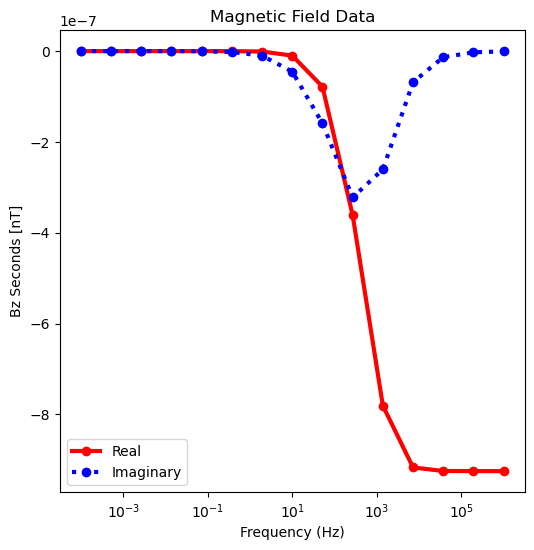

In [138]:
location_index = 10
d  = dpreds[location_index]
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.semilogx(frequencies, (10**9)*d[0::2], "r-o", lw=3)
ax.semilogx(frequencies, (10**9)*d[1::2], "b:o", lw=3)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Bz Seconds [nT]")
ax.set_title("Magnetic Field Data")
ax.legend(["Real", "Imaginary"])
plt.show()

### Save Data

In [141]:
if write_output:
    # Get the directory of the current notebook
    notebook_dir = os.getcwd()
    dir_path = os.path.join(notebook_dir, "3d_simulation_data")
    
    # Ensure the directory exists, create it if not
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

    np.random.seed(222)
    noise_level = 0.00 # Change this

    data = []

    for d in dpreds:
        noise = noise_level * np.abs(d) * np.random.rand(len(d))
        d += noise
        data.append(d[0::2]) # add real data
        data.append(d[1::2]) # add imaginary data
    
    fname = os.path.join(dir_path, "em3dfm_1d_data_3dMagFluxDens.txt")
    np.savetxt(
        fname,
        np.c_[frequencies, *data], #needed to modify this line
        fmt="%.4e",
        header="FREQUENCY HZ_REAL HZ_IMAG",
    )